# Efficient Frontiner from Modern Portfolio Theory implemented in Python

## Modern Portfolio Theory

Modern Portfolio Theory (MPT) is an investment theory developed by Harry Markowitz and published under the title "Portfolio Selection" in the Journal of Finance in 1952.

There are a few underlying concepts that can help anyone to understand MPT. If you are familiar with finance, you might know what the acronym "TANSTAAFL" stands for. It is a famous acronym for "There Ain't No Such Thing As A Free Lunch". This concept is also closely related to 'risk-return trade-off'.

Higher risk is associated with greater probability of higher return and lower risk with a greater probability of smaller return. MPT assumes that investors are risk-averse, meaning that given two portfolios that offer the same expected return, investors will prefer the less risky one. Thus, an investor will take on increased risk only if compensated by higher expected returns. 

Another factor comes in to play in MPT is "diversification". Modern portfolio theory says that it is not enough to look at the expected risk and return of one particular stock. By investing in more than one stock, an investor can reap the benefits of diversification – chief among them, a reduction in the riskiness of the portfolio.

What you need to understand is "risk of a portfolio is not equal to average/weighted-average of individual stocks in the portfolio". In terms of return, yes it is the average/weighted average of individual stock's returns, but that's not the case for risk. The risk is about how volatile the asset is, if you have more than one stock in your portfolio, then you have to take count of how these stocks movement correlates with each other. The beauty of diversification is that you can even get lower risk than a stock with the lowest risk in your portfolio, by optimising the allocation. 

I will try to explain as I go along with the actual code. First, let's start by importing some libraries we need. "Quandl" is a financial platform which also offers Python library. If you haven't installed it before, of course, you first need to install the package in your command line "pip install quandl", and before you can use it, you also need to get an API key on Quandl's website. Sign-up and getting an API key is free but has some limits. As a logged-in free user, you will be able to call 2,000 calls per 10 minutes maximum (speed limit), and 50,000 calls per day (volume limit). https://www.quandl.com/

In [1]:
#!pip install pandas_datareader
#!pip install quandl
!pip install pandas-datareader 
import pandas as pd
import numpy as np
import random

from pandas_datareader import data as web
from datetime import datetime
from matplotlib.ticker import FuncFormatter

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [152]:
# Include Cryptocurrencies first
#tickers = ['QCLN','VNQ','QQQ','AAPL','VOO','SCHD','ETH-USD','LTC-USD']
#tickers = ['BTC-USD','QCLN','VNQ','QQQ','AAPL','VOO', 'SCHD','FB','AMZN','GOOGL','TSLA','VTI','MSFT','EC']
tickers = ['LTC-USD','ETH-USD','QCLN','VNQ','QQQ','AAPL','VOO','SCHD']
num_crypto = 2
crypto_investment = 200
crypto_distribiuton = [100,100]

In [91]:
data = pd.DataFrame()
for item in tickers:
    data[item] = web.DataReader(item, data_source='yahoo', start='2015-8-30' , end='2021-05-9' )['Adj Close']
data = data.dropna()
data.head()


,LTC-USD,ETH-USD,QCLN,VNQ,QQQ,AAPL,VOO,SCHD
Date,,,,,,,,
2015-08-31,2.82001,1.35161,14.470125,58.167786,99.303062,25.923075,161.825439,30.513470
2015-09-01,2.79545,1.29479,14.041168,57.059891,96.199554,24.764400,156.884293,29.677708
2015-09-02,2.63314,1.26493,14.279478,57.649200,98.912758,25.826521,160.047348,30.195879
2015-09-03,2.70112,1.27441,14.536854,57.806328,98.427238,25.373627,160.181412,30.312895
2015-09-04,2.91954,1.33881,14.279478,56.729889,97.256279,25.120739,157.697418,29.828150


In [100]:
data.tail()

,LTC-USD,ETH-USD,QCLN,VNQ,QQQ,AAPL,VOO,SCHD
Date,,,,,,,,
2021-05-03,306.234497,3253.629395,63.340000,98.889999,336.190002,132.315247,384.440002,75.290001
2021-05-04,356.037079,3522.783203,60.650002,98.250000,330.140015,127.633202,382.100006,75.750000
2021-05-05,353.510345,3490.880371,60.150002,96.620003,329.029999,127.882790,382.170013,76.120003
2021-05-06,346.253571,3484.729004,59.049999,97.160004,331.510010,129.520004,385.279999,77.080002
2021-05-07,346.368744,3902.647705,60.049999,98.440002,334.200012,130.210007,388.029999,77.410004


Let's first look at how the price of each stock has evolved within give time frame.

Text(0, 0.5, 'price in $')

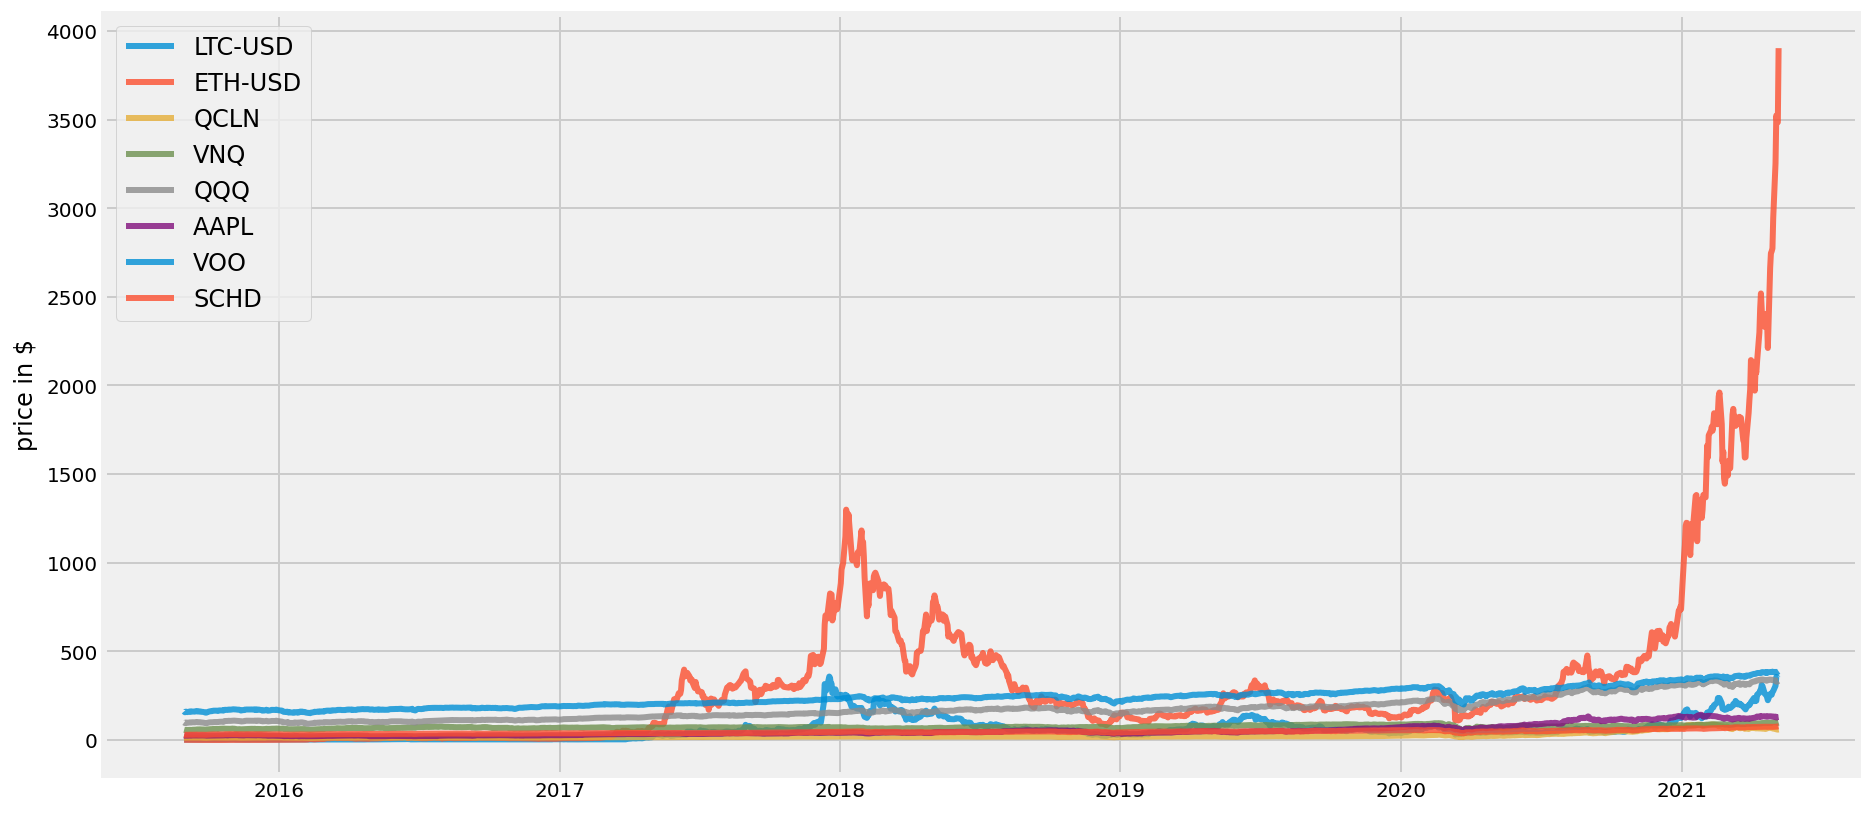

In [92]:
plt.figure(figsize=(14, 7))
for c in data.columns.values:
    plt.plot(data.index, data[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

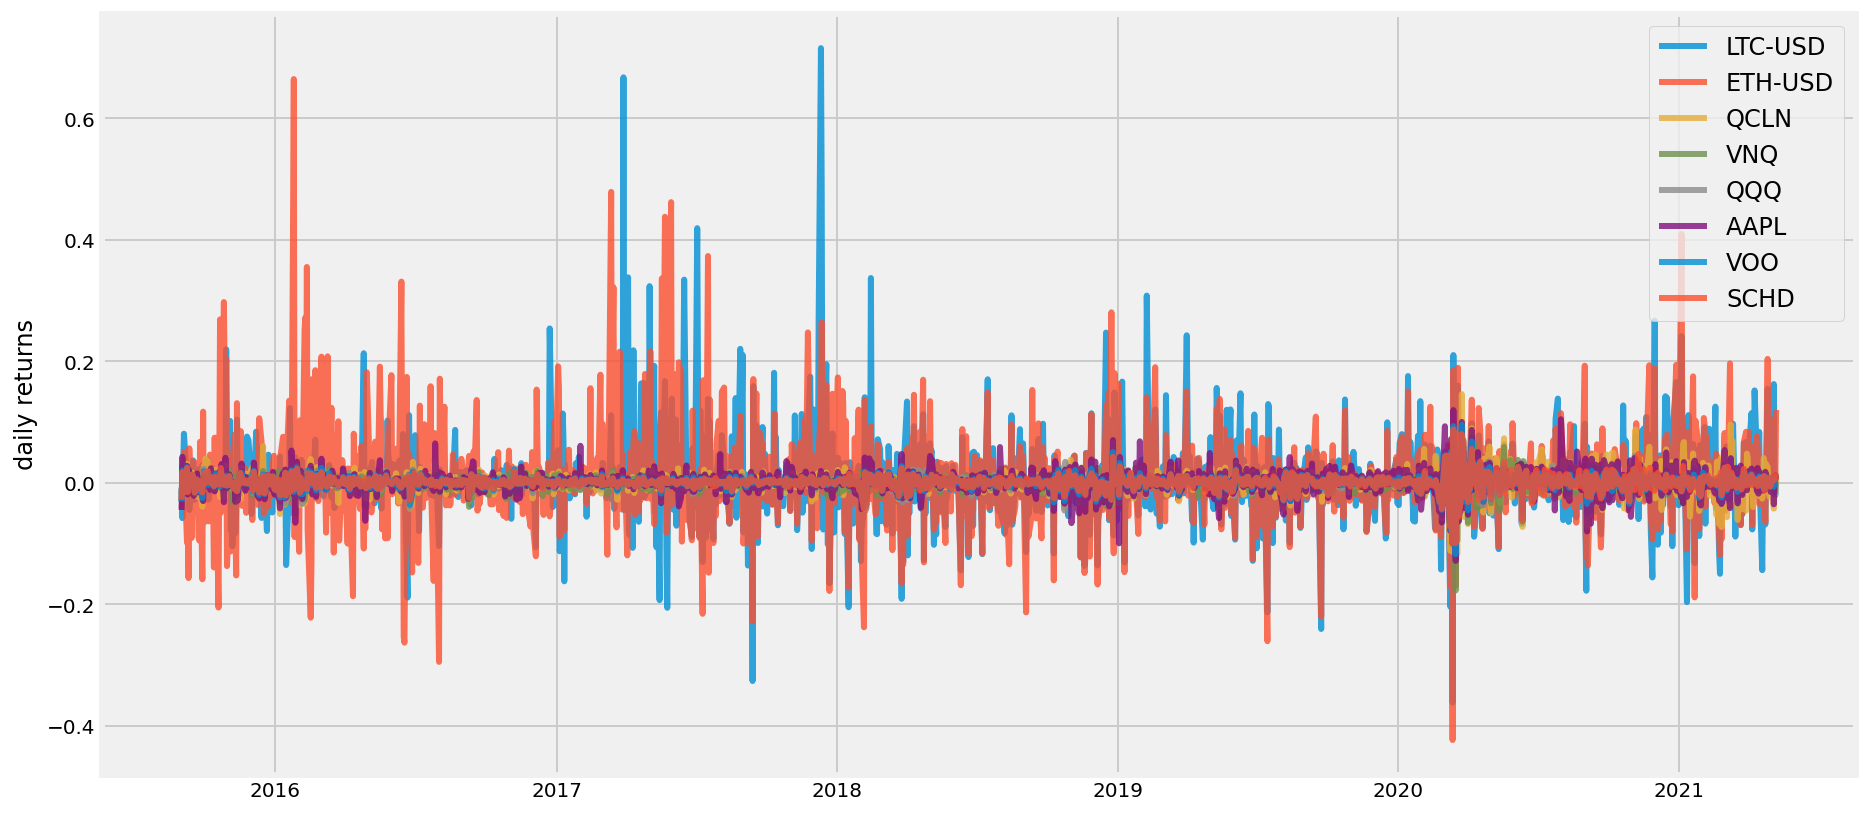

In [93]:
returns = data.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [97]:
daily_simple_returns = data.pct_change()
daily_simple_returns = daily_simple_returns.iloc[1:]
daily_simple_returns.head()

,LTC-USD,ETH-USD,QCLN,VNQ,QQQ,AAPL,VOO,SCHD
Date,,,,,,,,
2015-09-01,-0.008709,-0.042039,-0.029644,-0.019047,-0.031253,-0.044697,-0.030534,-0.027390
2015-09-02,-0.058062,-0.023062,0.016972,0.010328,0.028204,0.042889,0.020162,0.017460
2015-09-03,0.025817,0.007494,0.018024,0.002726,-0.004909,-0.017536,0.000838,0.003875
2015-09-04,0.080863,0.050533,-0.017705,-0.018621,-0.011897,-0.009967,-0.015507,-0.015991
2015-09-08,0.001500,-0.098819,0.031375,0.015097,0.028191,0.027821,0.025611,0.024377


In [98]:
annual_returns = daily_simple_returns.mean() * 250
annual_returns

LTC-USD    1.406883
ETH-USD    2.098415
QCLN       0.296575
VNQ        0.116267
QQQ        0.236476
AAPL       0.327163
VOO        0.170881
SCHD       0.179798
dtype: float64

In [151]:
#Portfolio Value

valor_port = sum(data[-1:].sum())-sum(data.iloc[-1:, 0:num_crypto].sum()) + crypto_investment
print("Portfolio Value: "+ str(valor_port))


Portfolio Value: 1288.3400230407715


In [159]:
data[-1:]

,LTC-USD,ETH-USD,QCLN,VNQ,QQQ,AAPL,VOO,SCHD
Date,,,,,,,,
2021-05-07,346.368744,3902.647705,60.049999,98.440002,334.200012,130.210007,388.029999,77.410004


In [173]:
num_assets = len(tickers)
weights = []

for i in range(num_crypto):
    weights.append(crypto_distribiuton[i]/valor_port)
    
for i in range(num_assets-num_crypto):
    weights.append(data[-1:].sum()[i+num_crypto]/valor_port)  
    
print(weights)
print("Sum: "+ str(sum(weights)))


[0.07761926060790812, 0.07761926060790812, 0.046610365402860864, 0.07640840203742624, 0.25940357842663636, 0.10106804444881123, 0.3011860159893652, 0.0600850724790839]
Sum: 0.9999999999999999


In [174]:
port_returns_expected = np.sum(weights * annual_returns)
port_returns_expected
print("Portafolio Expected returns: " + str(round(port_returns_expected * 100, 2)) + '%')


Portafolio Expected returns: 45.15%


In [175]:
inversion = 1000

print("Invested Amount: " + str(inversion))
print("Return after 1 year: " + str(inversion*(1+port_returns_expected)))
print("Diff: " + str(inversion*(1+port_returns_expected)-inversion) )

Invested Amount: 1000
Return after 1 year: 1451.464380084589
Diff: 451.46438008458904


## Random Portfolios Generation

We have 4 stocks in our portfolio. One decision we have to make is how we should allocate our budget to each of stock in our portfolio. If our total budget is 1, then we can decide the weights for each stock, so that the sum of weights will be 1. And the value for weights will be the portion of budget we allocate to a specific stock. For example, if weight is 0.5 for Amazon, it means that we allocate 50% of our budget to Amazon.

Let's define some functions to simulate random weights to each stock in the portfolio, then calculate the portfolio's overall annualised returns and annualised volatility.

"portfolio_annual_performance" function will calculate the returns and volatility, and to make it as an annualised calculation I take into account 252 as the number of trading days in one year. "random_portfolios" function will generate portfolios with random weights assigned to each stock, and by passing num_portfolios argument, you can decide how many random portfolios you want to generate.

In [176]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [177]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(data.columns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

You can easily get daily returns by calling pct_change on the data frame with the price data. And the mean daily returns, the covariance matrix of returns are needed to calculate portfolio returns and volatility. Finally, let's generate 25,000 portfolios with random weights assigned to each stock.

In [179]:
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.02805

mean_returns


LTC-USD    0.005628
ETH-USD    0.008394
QCLN       0.001186
VNQ        0.000465
QQQ        0.000946
AAPL       0.001309
VOO        0.000684
SCHD       0.000719
dtype: float64

Let me briefly explain what below function is doing. First, it generates random portfolio and gets the results (portfolio returns, portfolio volatility, portfolio Sharpe ratio) and weights for the corresponding result. Then by locating the one with the highest Sharpe ratio portfolio, it displays maximum Sharpe ratio portfolio as red star sign. And does similar steps for minimum volatility portfolio, and displays it as the green star on the plot. All the randomly generated portfolios will be also plotted with colour map applied to them based on the Sharpe ratio. The bluer, the higher Sharpe ratio.

And for these two optimal portfolios, it will also show how it allocates the budget within the portfolio.

In [180]:
cov_matrix

,LTC-USD,ETH-USD,QCLN,VNQ,QQQ,AAPL,VOO,SCHD
LTC-USD,0.004822,0.002633,0.000083,0.000069,0.000082,0.000090,0.000079,0.000063
ETH-USD,0.002633,0.005853,0.000083,0.000040,0.000064,0.000058,0.000068,0.000057
QCLN,0.000083,0.000083,0.000377,0.000148,0.000197,0.000215,0.000172,0.000150
VNQ,0.000069,0.000040,0.000148,0.000190,0.000115,0.000121,0.000124,0.000120
QQQ,0.000082,0.000064,0.000197,0.000115,0.000191,0.000216,0.000151,0.000125
AAPL,0.000090,0.000058,0.000215,0.000121,0.000216,0.000355,0.000166,0.000132
VOO,0.000079,0.000068,0.000172,0.000124,0.000151,0.000166,0.000141,0.000128
SCHD,0.000063,0.000057,0.000150,0.000120,0.000125,0.000132,0.000128,0.000134


In [181]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80) 
    print("Maximum Sharpe Ratio Portfolio Allocation\n") 
    print("Annualised Return:", round(rp,2)) 
    print("Annualised Volatility:", round(sdp,2)) 
    print("\n") 
    print(max_sharpe_allocation) 
    print("-"*80) 
    print("Minimum Volatility Portfolio Allocation\n") 
    print("Annualised Return:", round(rp_min,2)) 
    print("Annualised Volatility:", round(sdp_min,2)) 
    print("\n") 
    print(min_vol_allocation) 
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.71
Annualised Volatility: 0.34


            LTC-USD  ETH-USD   QCLN   VNQ   QQQ   AAPL   VOO   SCHD
allocation      7.7    19.17  15.41  0.44  7.49  24.32  1.82  23.66
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.2
Annualised Volatility: 0.18


            LTC-USD  ETH-USD  QCLN    VNQ   QQQ  AAPL    VOO   SCHD
allocation     1.75     0.65  2.89  29.08  6.48  1.76  21.64  35.75


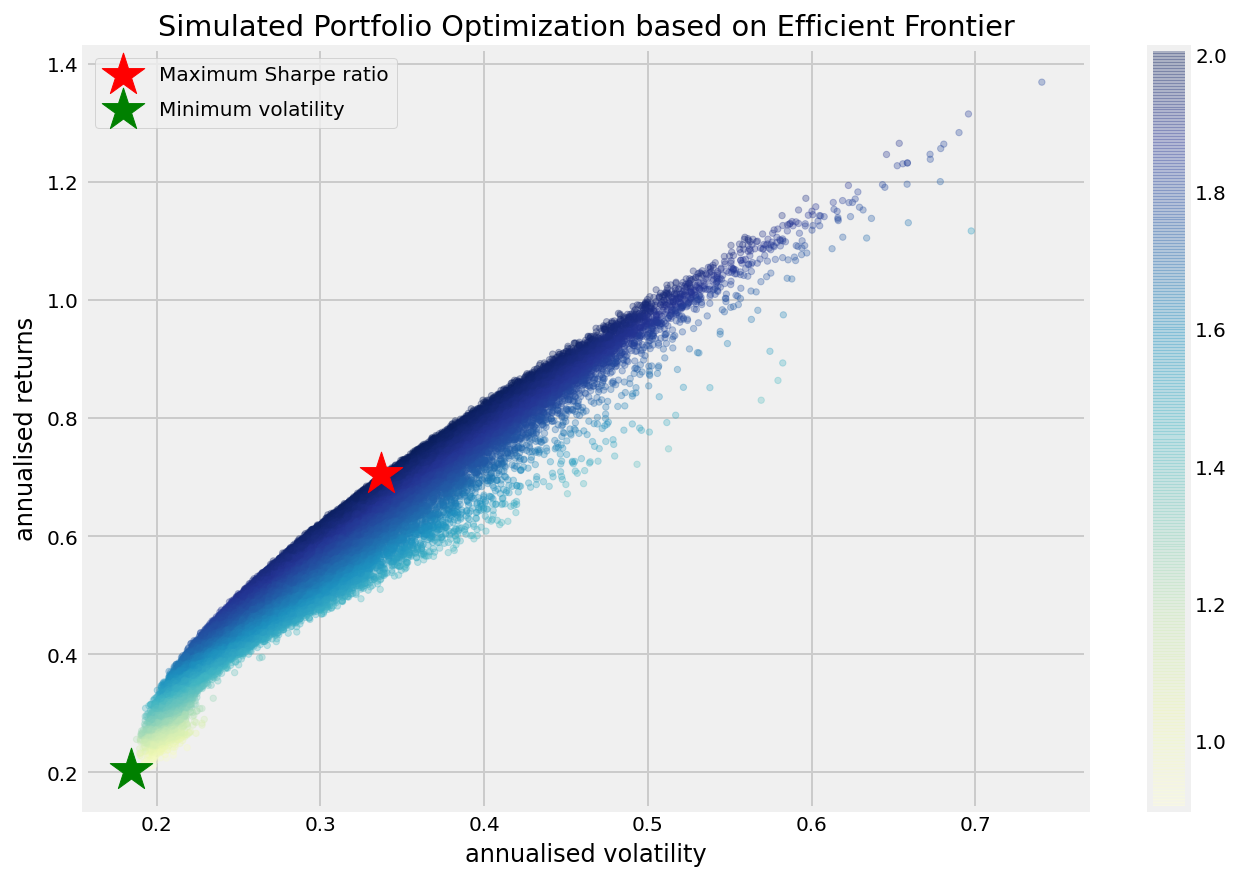

In [182]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

For minimum risk portfolio, we can see that more than half of our budget is allocated to Google. If you take another look at the daily return plot from earlier, you can see that Google is the least volatile stock of four, so allocating a large percentage to Google for minimum risk portfolio makes intuitive sense.

If we are willing to take higher risk for higher return, one that gives us the best risk-adjusted return is the one with maximum Sharpe ratio. In this scenario, we are allocating a significant portion to Amazon and Facebook, which are quite volatile stocks from the previous plot of daily returns. And Google which had more than 50% allocation in the minimum risk portfolio, has less than 1% budget allocated to it.

## Efficient Frontier

From the plot of the randomly simulated portfolio, we can see it forms a shape of an arch line on the top of clustered blue dots. This line is called efficient frontier. Why is it efficient? Because points along the line will give you the lowest risk for a given target return. All the other dots right to the line will give you higher risk with same returns. If the expected returns are the same, why would you take an extra risk when there's an option with lower risk?

The way we found the two kinds of optimal portfolio above was by simulating many possible random choices and pick the best ones (either minimum risk or maximum risk-adjusted return). We can also implement this by using Scipy's optimize function.

If you are an advanced Excel user, you might be familiar with 'solver' function in excel. Scipy's optimize function is doing the similar task when given what to optimize, and what are constraints and bounds.

Below functions are to get the maximum Sharpe ratio portfolio. In Scipy's optimize function, there's no 'maximize', so as an objective function you need to pass something that should be minimized. That is why the first "neg_sharpe_ratio" is computing the negative Sharpe ratio. Now we can use this as our objective function to minimize. In "max_sharpe_ratio" function, you first define arguments (this should not include the variables you would like to change for optimisation, in this case, "weights"). At first, the construction of constraints was a bit difficult for me to understand, due to the way it is stated. 

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

The above constraint is saying that sum of x should be equal to 1. You can think of the 'fun' part construction as '1' on the right side of equal sign has been moved to the left side of the equal sign.

'np.sum(x) == 1' has become 'np.sum(x)-1'

And what does this mean? It simply means that the sum of all the weights should be equal to 1. You cannot allocate more than 100% of your budget in total.

"bounds" is giving another limit to assign random weights, by saying any weight should be inclusively between 0 and 1. You cannot give minus budget allocation to a stock or more than 100% allocation to a stock.

In [183]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

We can also define the optimizing function for calculating minimum volatility portfolio. This time we really do minimize the objective function. What do we want to minimize? We want to minimize volatility by trying different weights. "constraints" and "bounds" are same as the above.

In [184]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

As I already mentioned above we can also draw a line which depicts where the efficient portfolios for a given risk rate should be. This is called "efficient frontier". Below I define other functions to compute efficient frontier. The first function "efficient_return" is calculating the most efficient portfolio for a given target return, and the second function "efficient_frontier" will take a range of target returns and compute efficient portfolio for each return level.

In [185]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

Let's try to plot the portfolio choice with maximum Sharpe ratio and minimum volatility also with all the randomly generated portfolios. But this time we are not picking the optimal ones from the randomly generated portfolios, but we are actually calculating by using Scipy's 'minimize' function. And the below function will also plot the efficient frontier line.

In [186]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80) 
    print("Maximum Sharpe Ratio Portfolio Allocation\n") 
    print("Annualised Return:", round(rp,2)) 
    print("Annualised Volatility:", round(sdp,2)) 
    print("\n") 
    print(max_sharpe_allocation) 
    print("-"*80) 
    print("Minimum Volatility Portfolio Allocation\n") 
    print("Annualised Return:", round(rp_min,2)) 
    print("Annualised Volatility:", round(sdp_min,2)) 
    print("\n") 
    print(min_vol_allocation) 
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.79
Annualised Volatility: 0.38


            LTC-USD  ETH-USD   QCLN  VNQ  QQQ   AAPL  VOO  SCHD
allocation     8.12     22.0  18.82  0.0  0.0  42.85  0.0  8.21
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.21
Annualised Volatility: 0.18


            LTC-USD  ETH-USD  QCLN    VNQ    QQQ  AAPL  VOO   SCHD
allocation     0.85      0.9   0.0  15.76  10.75   0.0  0.0  71.74


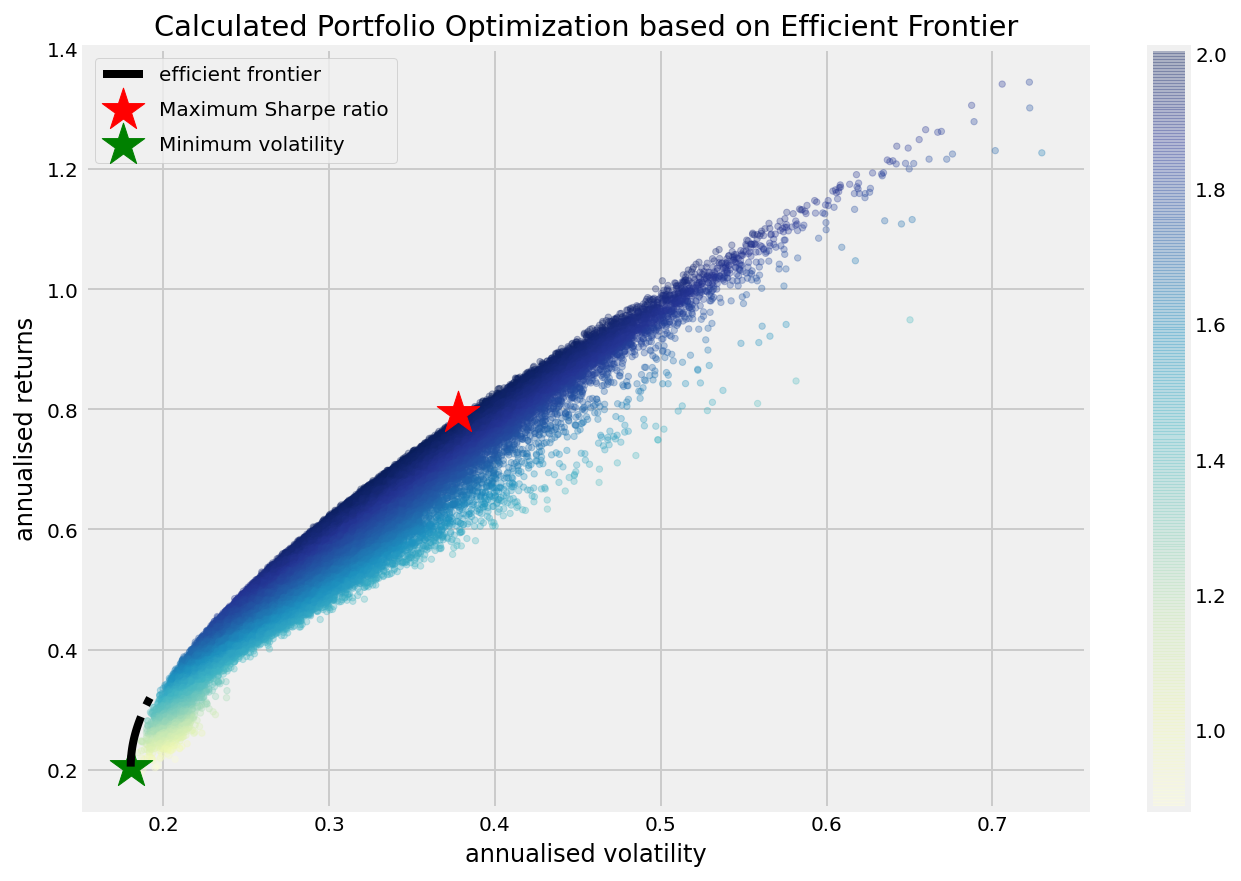

In [187]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

We have almost the same result as what we have simulated by picking from the randomly generated portfolios. The slight difference is that the Scipy's "optimize" function has not allocated any budget at all for Google on maximum Sharpe ratio portfolio, while one we chose from the randomly generated samples has 0.45% of allocation for Google. There are some differences in the decimal places but more or less same.

Instead of plotting every randomly generated portfolio, we can plot each individual stocks on the plot with the corresponding values of each stock's annual return and annual risk. This way we can see and compare how diversification is lowering the risk by optimising the allocation.

In [188]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print("-"*80) 
    print("Maximum Sharpe Ratio Portfolio Allocation\n") 
    print("Annualised Return:", round(rp,2)) 
    print("Annualised Volatility:", round(sdp,2)) 
    print("\n") 
    print(max_sharpe_allocation) 
    print("-"*80) 
    print("Minimum Volatility Portfolio Allocation\n") 
    print("Annualised Return:", round(rp_min,2)) 
    print("Annualised Volatility:", round(sdp_min,2)) 
    print("\n") 
    print(min_vol_allocation) 
    print("-"*80)
    print("Individual Stock Returns and Volatility\n") 
    for i, txt in enumerate(data.columns):
        print(txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2)) 
    print("-"*80) 
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(data.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.79
Annualised Volatility: 0.38


            LTC-USD  ETH-USD   QCLN  VNQ  QQQ   AAPL  VOO  SCHD
allocation     8.12     22.0  18.82  0.0  0.0  42.85  0.0  8.21
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.21
Annualised Volatility: 0.18


            LTC-USD  ETH-USD  QCLN    VNQ    QQQ  AAPL  VOO   SCHD
allocation     0.85      0.9   0.0  15.76  10.75   0.0  0.0  71.74
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

LTC-USD : annuaised return 1.42 , annualised volatility: 1.1
ETH-USD : annuaised return 2.12 , annualised volatility: 1.21
QCLN : annuaised return 0.3 , annualised volatility: 0.31
VNQ : annuaised return 0.12 , annualised volatility: 0.22
QQQ : annuaised return 

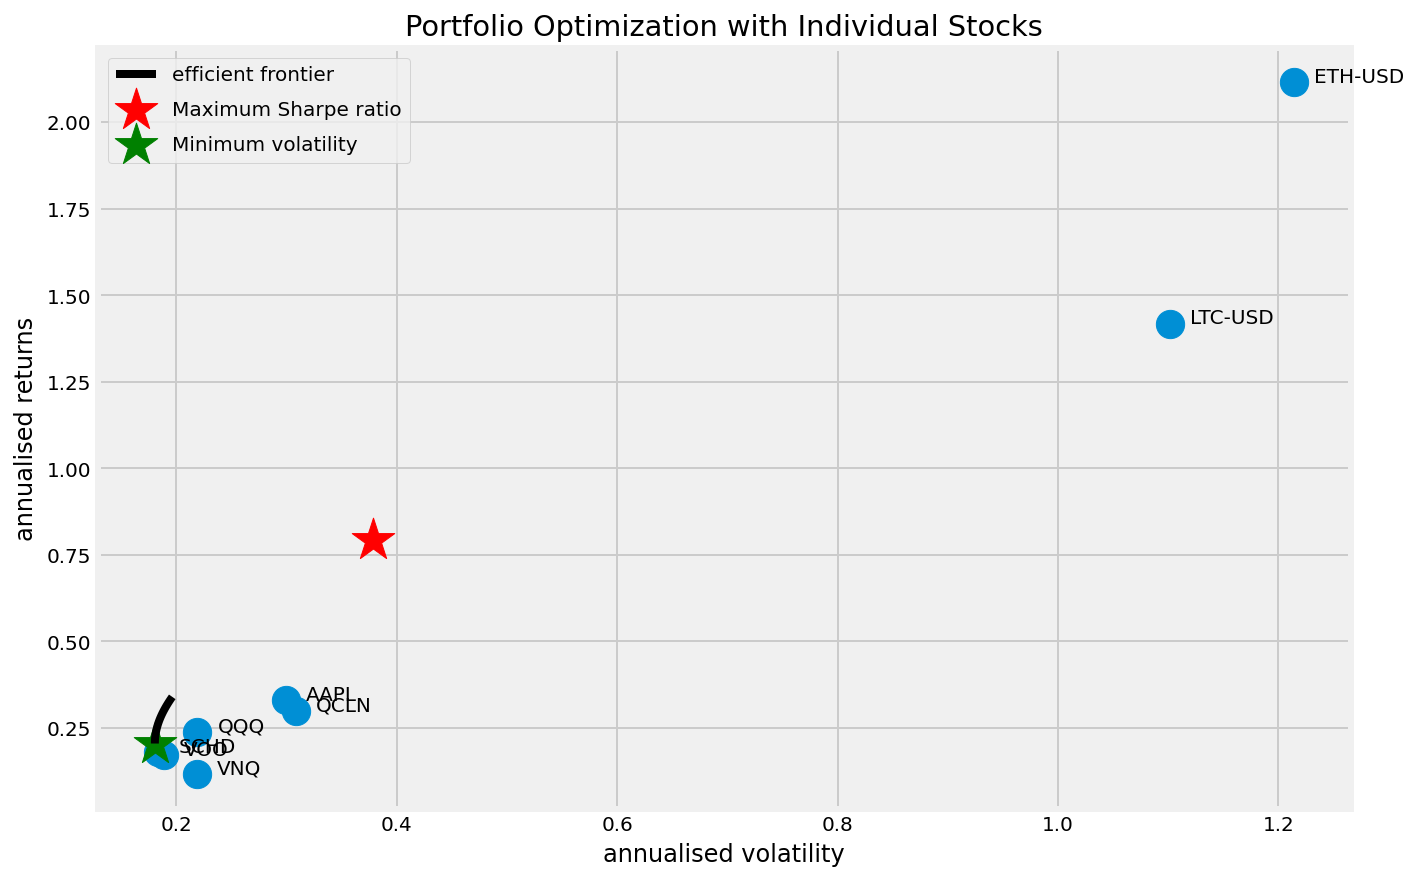

In [189]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

As you can see from the above plot, the stock with the least risk is Google at around 0.18. But with portfolio optimisation, we can achieve even lower risk at 0.16, and still with a higher return than Google. And if we are willing to take slightly more risk at around the similar level of risk of Google, we can achieve a much higher return of 0.30 with portfolio optimization.

Considering how vast and deep the finance field is, I've probably only scratched the surface. But I had fun going through coding and trying to understand the concept. And I'm learning every day. After finishing this implementation, I definitely know better than yesterday's me. And if I keep on going and learning, in about a couple of year's time, I will know a whole lot more than today's me. If you have any comments or questions, feel free to leave a comment. Any feedback would be appreciated.